# 14장

In [2]:
import tensorflow as tf, os
import warnings
warnings.filterwarnings('ignore')

tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 증가 방지 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
os.putenv('TF_GPU_ALLOCATOR', 'cuda_malloc_async')

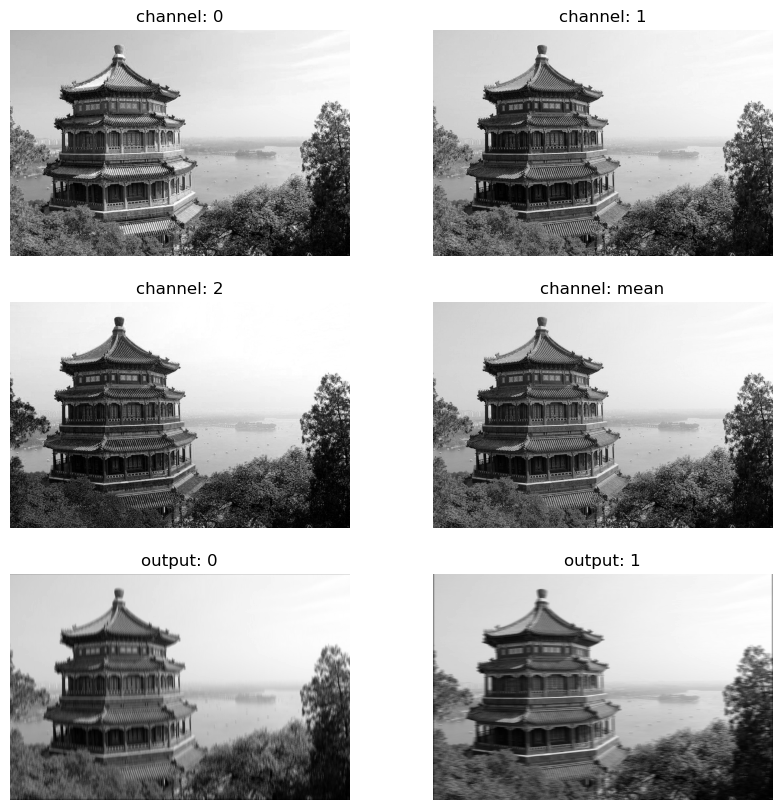

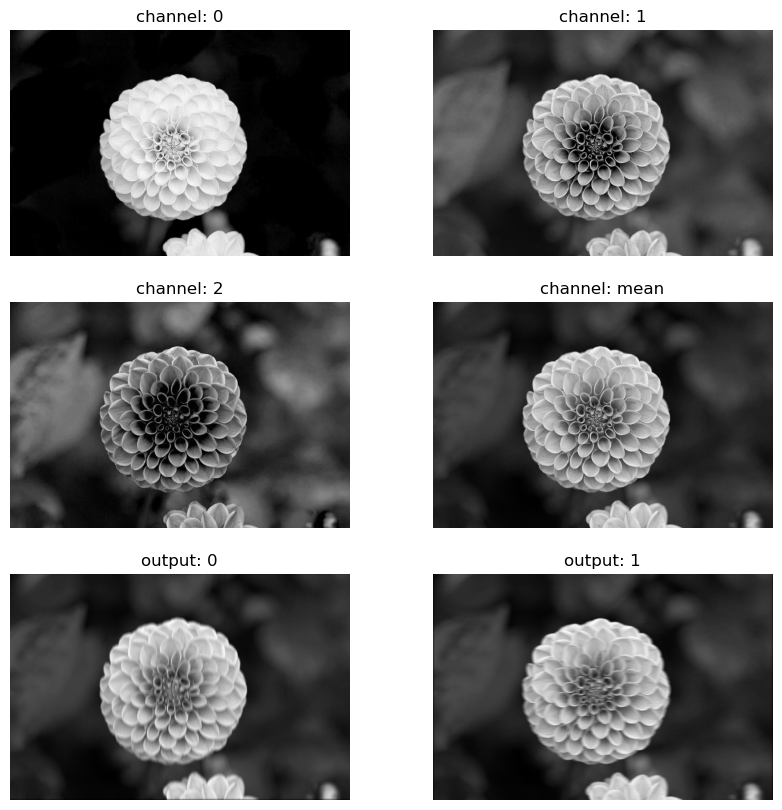

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # 수직선
filters[3, :, :, 1] = 1 # 수평선

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

for image_index in (0, 1):
    plt.figure(figsize=(10, 10))
    for channel in range(channels):
        plt.subplot(3, 2, channel+1, title=f'channel: {channel}')
        plt.imshow(images[image_index, :, :, channel], cmap='gray')
        plt.axis("off")

    plt.subplot(3, 2, 4, title='channel: mean')
    plt.imshow(images[image_index].mean(axis=2).reshape(-1, 640, 1), cmap='gray')
    plt.axis("off")

    plt.subplot(3, 2, 5, title='output: 0')
    plt.imshow(outputs[image_index, :, :, 0], cmap='gray')
    plt.axis("off")

    plt.subplot(3, 2, 6, title='output: 1')
    plt.imshow(outputs[image_index, :, :, 1], cmap='gray')
    plt.axis("off")

    plt.show(block=False)
    plt.pause(2)
    plt.close()

In [4]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')

In [5]:
outputs.shape

TensorShape([2, 427, 640, 2])

In [6]:
conv2 = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

conv_outputs = conv(images)
conv_outputs2 = conv2(images)
conv_outputs.shape, conv_outputs2.shape

(TensorShape([2, 427, 640, 32]), TensorShape([2, 427, 640, 2]))

In [7]:
with tf.device('/CPU:0'):
    output = tf.nn.max_pool(images,
                            ksize=(1, 1, 1, 3),
                            strides=(1, 1, 1, 3),
                            padding='VALID')    # 패딩 없음

In [8]:
depth_pool = keras.layers.Lambda(lambda X: 
                                 tf.nn.max_pool(X, 
                                                ksize=(1, 1, 1, 3), 
                                                strides=(1, 1, 1, 3), 
                                                padding='valid'))

In [9]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Epoch 1/10
54/54 [==============================] - 68s 1s/step - loss: 1.2942 - accuracy: 0.5506 - val_loss: 0.5709 - val_accuracy: 0.8062
Epoch 2/10
54/54 [==============================] - 73s 1s/step - loss: 0.6479 - accuracy: 0.7781 - val_loss: 0.4164 - val_accuracy: 0.8556
Epoch 3/10
54/54 [==============================] - 91s 2s/step - loss: 0.4935 - accuracy: 0.8343 - val_loss: 0.3374 - val_accuracy: 0.8782
Epoch 4/10
54/54 [==============================] - 97s 2s/step - loss: 0.4222 - accuracy: 0.8613 - val_loss: 0.3121 - val_accuracy: 0.8886
Epoch 5/10
54/54 [==============================] - 99s 2s/step - loss: 0.3726 - accuracy: 0.8772 - val_loss: 0.2875 - val_accuracy: 0.8932
Epoch 6/10
54/54 [==============================] - 90s 2s/step - loss: 0.3310 - accuracy: 0.8923 - val_loss: 0.2948 - val_accuracy: 0.8978
Epoch 7/10
54/54 [==============================] - 101s 2s/step - loss: 0.3045 - accuracy: 0.9003 - val_loss: 0.2623 - val_accuracy: 0.9102
Epoch 8/10
54/54 [=

In [12]:
lenet = keras.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='same', activation='tanh', input_shape=(28,28,1)),
    keras.layers.AvgPool2D(pool_size=2, strides=2),
    keras.layers.Conv2D(16, 5, 1, 'same', activation='tanh'),
    keras.layers.AvgPool2D(2, 2),
    keras.layers.Conv2D(120, 5, 1, 'same', activation='tanh'),
    keras.layers.Flatten(),
    keras.layers.Dense(84, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])
lenet.summary()
del lenet

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 7, 7, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 120)         48120     
                                                                 
 flatten_1 (Flatten)         (None, 5880)             

In [13]:
alexnet = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(227, 227, input_shape=(28, 28, 3)),
    keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, padding='valid', activation='relu'),
    keras.layers.Lambda(tf.nn.lrn),    # 정규화, 요즘은 BatchNormalization 사용
    keras.layers.MaxPool2D(pool_size=3, strides=2),
    keras.layers.Conv2D(256, 5, 1, 'same', activation='relu'),
    keras.layers.Lambda(tf.nn.local_response_normalization),   # lrn 풀네임
    keras.layers.MaxPool2D(pool_size=3, strides=2),
    keras.layers.Conv2D(384, 3, 1, 'same', activation='relu'),
    keras.layers.Conv2D(384, 3, 1, 'same', activation='relu'),
    keras.layers.Conv2D(256, 3, 1, 'same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=3, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
alexnet.summary()
del alexnet

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 227, 227, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 lambda_2 (Lambda)           (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 lambda_3 (Lambda)           (None, 27, 27, 256)       0         
                                                      

In [14]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False),
            keras.layers.BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        
        return self. activation(Z + skip_Z)

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary();

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

In [16]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')
images_resized = tf.image.resize(images, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print('이미지 #{}'.format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print('  {} - {:12s} {:.2f}%'.format(class_id, name, y_proba*100))
    print()

1/1 [==============================] - 1s 954ms/step
이미지 #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

이미지 #1
  n03530642 - honeycomb    49.81%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%



In [17]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

In [18]:
test_set, valid_set, train_set = tfds.load("tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [19]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    
    return final_image, label

batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [20]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

print(len(base_model.trainable_variables), len(model.trainable_variables))
for layer in base_model.layers:
    layer.trainable = False
print(len(base_model.trainable_variables), len(model.trainable_variables))

base_model.trainable = True
print(len(base_model.trainable_variables), len(model.trainable_variables))
base_model.trainable = False
print(len(base_model.trainable_variables), len(model.trainable_variables))

154 156
0 2
154 156
0 2


In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 130s 1s/step - loss: 1.4487 - accuracy: 0.7896 - val_loss: 1.0774 - val_accuracy: 0.8403
Epoch 2/5
86/86 [==============================] - 123s 1s/step - loss: 0.8339 - accuracy: 0.8837 - val_loss: 1.3120 - val_accuracy: 0.8348
Epoch 3/5
86/86 [==============================] - 123s 1s/step - loss: 0.6469 - accuracy: 0.9062 - val_loss: 1.1404 - val_accuracy: 0.8730
Epoch 4/5
86/86 [==============================] - 124s 1s/step - loss: 0.4466 - accuracy: 0.9331 - val_loss: 1.3701 - val_accuracy: 0.8675
Epoch 5/5
86/86 [==============================] - 126s 1s/step - loss: 0.3375 - accuracy: 0.9375 - val_loss: 1.2155 - val_accuracy: 0.8657


In [22]:
print(len(base_model.trainable_variables), len(model.trainable_variables))
base_model.trainable = True
print(len(base_model.trainable_variables), len(model.trainable_variables))

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, epochs=3, validation_data=valid_set)

0 2
154 156
Epoch 1/3
86/86 [==============================] - 425s 5s/step - loss: 0.5569 - accuracy: 0.8427 - val_loss: 1.2910 - val_accuracy: 0.8004
Epoch 2/3
86/86 [==============================] - 408s 5s/step - loss: 0.1349 - accuracy: 0.9611 - val_loss: 0.4496 - val_accuracy: 0.8784
Epoch 3/3
86/86 [==============================] - 413s 5s/step - loss: 0.0482 - accuracy: 0.9851 - val_loss: 0.2930 - val_accuracy: 0.9165


In [23]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # 어떤 것을 중요하게 생각하느냐에 따라
              optimizer=optimizer, metrics=["accuracy"])

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [25]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 42s 24ms/step - loss: 0.1946 - accuracy: 0.9421 - val_loss: 0.0396 - val_accuracy: 0.9894
Epoch 2/10
1719/1719 [==============================] - 45s 26ms/step - loss: 0.0790 - accuracy: 0.9765 - val_loss: 0.0369 - val_accuracy: 0.9892
Epoch 3/10
1719/1719 [==============================] - 53s 31ms/step - loss: 0.0613 - accuracy: 0.9813 - val_loss: 0.0359 - val_accuracy: 0.9894
Epoch 4/10
1719/1719 [==============================] - 45s 26ms/step - loss: 0.0486 - accuracy: 0.9849 - val_loss: 0.0344 - val_accuracy: 0.9912
Epoch 5/10
1719/1719 [==============================] - 45s 26ms/step - loss: 0.0418 - accuracy: 0.9871 - val_loss: 0.0306 - val_accuracy: 0.9918
Epoch 6/10
1719/1719 [==============================] - 52s 30ms/step - loss: 0.0369 - accuracy: 0.9887 - val_loss: 0.0295 - val_accuracy: 0.9918
Epoch 7/10
1719/1719 [==============================] - 42s 25ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.0343 -

[0.03089313395321369, 0.9918000102043152]